In [1]:
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='notebook', style='whitegrid')

# ポケモンで因果推論

## 1. 背景
東大にいる友人のNA氏がこないだ面白いブログを紹介してくれた。テーマはなんとあのポケモンで因果推論をしようというもの。自分もちょうど半年以上統計学を学んで、これから入ろうと思っていたゼミのために[「計量経済学の第一歩」](https://www.amazon.co.jp/計量経済学の第一歩-実証分析のススメ-有斐閣ストゥディア-田中/dp/4641150281)を読んでいたので、楽しく知識の整理するのにピッタリのブログだった。自分の統計学とプログラミングに関する知識を利用してさらに発展させるのが目標である。

## 2. 問題設定
以下[「ポケモンを題材に因果推論を実践してみる」](https://tepppei.hatenablog.com/entry/2020/05/05/113514)から引用している：

今は昔、モンスターボールしか存在せず、スーパーボールが世の中で出回り始めたばかりの頃、オーキド博士が「スーパーボールは本当にモンスターボールより捕まえやすいのか？」という仮説を検証しようとしています。
そこでオーキド博士は世界中のトレーナーたちからデータを収集し、下記のような100件のデータを収集することができました。

## 3. データの生成

### 捕獲アルゴリズム
日本のオタク文化はすごいというか、ポケモンボールを投げた時にポケモンが獲得できるかどうかの仕組みがしっかりと研究されている。しかも世代ごとに。[「ポケモンWiki獲得処理」](https://wiki.ポケモン.com/wiki/捕獲処理)をもとにデータ生成をPython行っていく。ざっくりまとめると以下の様なアルゴリズムらしい。

1. **マスターボール**を使用した場合、自動的に捕獲成功となり以下の処理は無視される。


2. **モンスターボール**を使用した場合、0~255の乱数を生成する。この乱数を$R_1$とする。


3. $R_1 - X_{status}$(乱数 - 状態補正[※1])を計算する。$R_1-X_{status}$が0以下の場合は捕獲成功。ポケモンそれぞれが持つ被捕獲度$X_{capture}$[※2]より低いが0以上の場合、さらに0~255の乱数$R_2$を発生。


4. $R_2 < F$[※3]以下のとき、獲得成功。$F$より大きいとき、獲得失敗。

※1 状態補正$X_{status}$とは捕獲を試みるポケモンのねむり、こおり、まひ、やけど、どく等の状態異常にかかっているときの補正度合いのことを指している。ねむり・こおりの場合25、まひ・やけど・どくの場合12である。

※2 $X_{capture}$はポケモンのレア度にボールによる補正をかけた値である。最大値は255である。
* モンスターボール：$X_{capture}$ = $X_{rarity}$
* スーパーボール: $X_{capture} = 1.5X_{rarity}$
* ハイパーボール: $X_{capture} = 2X_{rarity}$

※3 $F = \frac{255 \times MaxHP}{4 \times BallCoef \times HP}$ 
* $BallCoef$：スーパーボールの場合8、それ以外の場合12。


### ポケモンのステータス
それでは早速Pythonでモンスターボールとポケモンを実装して、捕まえに行こう！と思ったけど、待てポケモンのレア度ってどうやって計算するの？最大HP、モンスターボールを投げた時のHPは？状態異常は？あれ、あれ、あれ？と色々考えなければいけない事があると気づいたのでさらに調査...。

1. ポケモンのレア度は[ポケモンWiki](https://wiki.ポケモン.com/wiki/捕捉率)に有ったので第二世代までのデータ(フシギダネからセレブィまで)スクレーピングした。


2. ポケモンの最大HPはどうやら次の様に決まってくるらしい。

$$2 \times \left((X_{race} + X_{indiv})+X_{work}\right) \times \frac{X_{level}}{100} + X_{level} + 10$$


* ここで$X_{race}$は種族値、$X_{indiv}$は個体値、$X_{work}$は努力値のことを意味する。つまり、最大HPは種族、個体、努力、定数とし、レベルを変数とした一次関数ですね。そしてポケモンの世界において努力は決して遺伝に勝てないことも式から見えてきた。なんて残酷な世界だ...(ちなみに第三世代以降さらに残酷な設定になっている)。


* 種族値のデータもまたポケモンWikiで見つかったのでそれもスクレーピングしてきた。レア度とは別のcsvファイルに書き込んでRelational Databaseを作る(カッコイイから単語を使いたかっただけ)。


* HPの個体値に関しては、どうやら色々細かい設定があるらしいが、とりあえず0~15の値をとるらしいので一様分布でランダムに生成することに。


* 努力レベルはポケモンを捕まえた後に増えていくものなので無視してよい。


* ポケモンのレベルの扱いはもう少し複雑になってくる。ポケモンを遊んだことがある人はわかると思うが、ゲーム序盤に出てくるポケモンのレベルは低くて、ゲームを進めていくにつれレベルが上昇していく。どこかの攻略本に野生ポケモンのレベルについて書かれてそうだが、俺もそれを全て集めてくるほど暇人では無いので(じゃあこのブログはなんなんだよ)、とりあえずここは**ポケモンのレベルは$\mu=36, \sigma=12$の標準分布に従うと仮定**する。というのも、経験上野生のポケモンはレベル5~59くらいで、この様な標準分布を使えばそれなりに良い感じのシミュレーションができるのではないかと思ったからだ。だからData Scientistはドメイン知識が重要なのです(ちがう)。


3. モンスターボールを投げた時のポケモンのHPは時と場合によって大きく変わってくる。弱いポケモンはHPを減らさなくても簡単に捕まるが、強いポケモンはHPを減らしてからボールを投げるのが捕獲の鉄則になっている。これに関しては本当に統計データがないとモデリングできないが、そんなデータ転がってるわけが無いので、諦めて**1~最大HPまでの一様分布に従うと仮定する**。


4. モンスターボールを投げた時、ポケモンが状態異常かどうかもまた色々と仮定をしなければいけない。自分はめんどくさがり屋なので状態異常とかに頼らずモンスターボールの数でゴリ押しするスタイルだが、人によってはちゃんと催眠術をかけて眠らせたり、電気ショックで麻痺らせたり、冷たいビームで凍らせたり、毒をもったり(ポケモンも大変だな...)して捕獲しやすくしている。取り合えず**5分の1の確率でなんらかの状態異常にかかっていると仮定**する。

これらのことを反映させるよう実装を進めていく。

### 実装
#### ポケモン

In [2]:
class Pokemon:
    def __init__(self,
                 _id: str,
                 name: str,
                 rarity: int,
                 race: int
                ) -> None:
        self._state_mapper = dict(
            asleep=25,
            freeze=25,
            burn=12,
            paralysis=12,
            poison=12,
            normal=0
        )
        self.id = _id
        self.name = name
        self.rarity = rarity
        self.race = race
        self.state = get_state()
        self.level = get_level()
        self.hp_max = np.round(2*(self.race + np.random.randint(0, 15))*self.level/100 + self.level + 10)
    
    def set_hp(self):
        self.hp = self.hp_max - np.random.randint(0, self.hp_max)
        
    def get_state_adjustment(self) -> int:
        return self._state_mapper[self.state]

#### モンスターボール

In [3]:
class Ball:
    def __init__(self, ball_type: str) -> None:
        '''
        ball_type: monster, super, or hyper
        '''
        self._rand_var_upper_bounds = {
            'monster': 256,
            'super': 201,
            'hyper': 151
        }
        self._ball_coef_map = {
            'monster': 12,
            'super': 8,
            'hyper': 12
        }
        self._rarity_coef_map = {
            'monster': 1,
            'super': 1.5,
            'hyper': 2.0
        }
        self.ball_type = ball_type
    
    def get_random_variable(self) -> int:
        u_bound = self._rand_var_upper_bounds[self.ball_type]
        return np.random.randint(0, u_bound)
    
    def get_coefficient(self) -> int:
        return self._ball_coef_map[self.ball_type]
    
    def get_rarity_coefficient(self, rarity) -> int:
        r_coef = self._rarity_coef_map[self.ball_type] * rarity
        if r_coef <= 255:
            return r_coef
        return 255

#### 捕獲に使うボールの数を計算する関数

In [4]:
def _calculate_f_value(ball: Ball, pokemon: Pokemon) -> int:
    numerator = int(pokemon.hp_max * 255 / ball.get_coefficient())
    denominator = int(pokemon.hp / 4)
    f_value = numerator / denominator if denominator > 0 else numerator
    return min(255, f_value)

In [5]:
def judge_capture(ball: Ball, pokemon: Pokemon) -> bool:
    
    pokemon.set_hp()
    
    if ball.ball_type == 'master':
        return True
    
    first_rand_var = ball.get_random_variable() - pokemon.get_state_adjustment()
    if first_rand_var < 0:
        return True
    if first_rand_var > ball.get_rarity_coefficient(pokemon.rarity):
        return False
    
    second_rand_var = np.random.randint(0, 256)
    if second_rand_var <= _calculate_f_value(ball, pokemon):
        return True
    return False

In [6]:
def count_thrown_balls(ball: Ball, pokemon: Pokemon) -> int:

    def f(n: int) -> int:
        if judge_capture(ball=ball, pokemon=pokemon):
            return n
        return f(n + 1)

    return f(1)

#### レベルと状態異常をセットする関数
* `get_level`: ポケモンのレベルを標準分布から算出
* `get_state`: ポケモンの状態異常を1/5の確率で発生

In [7]:
def get_level(mu = 36, sigma = 12):
    n = np.random.normal(mu, sigma)
    if n < 5:
        return 5
    elif n > 100:
        return 100
    else:
        return np.round(n)

In [8]:
def get_state():
    states = ['asleep', 'freeze', 'burn', 'paralysis', 'poison']
    if np.random.randint(1, 6) == 1:
        return np.random.choice(states, 1)[0]
    else: return 'normal'

#### 使うボールを決める
ポケモンの「珍しさ」は3から255までである。数値が小さいほど珍しいということを意味する。ポケモンのレベルは1から100までである。
ポケモンが珍しいほどまたポケモンのレベルが高いほど人はモンスターボールよりスーパーボールを使うという仮定である。これをうまく反映させたい。[「ポケモンを題材に因果推論を実践してみる」](https://tepppei.hatenablog.com/entry/2020/05/05/113514)のソースコードを覗いて見た結果、ベルヌーイ分布のパラメーター$p$を以下の様にモデリングしている。$$p = \frac{255}{245} - \frac{C_{rarity}}{245}$$
私はレベルのことも考慮したいので$p$を以下の様に定義することにする。
$$p = 1 - \frac{1}{255}C_{rarity}-\frac{1}{100}(100-Level) + \frac{1}{255*100}C_{rarity}(100-Level)$$

In [9]:
def decide_ball(rarity: int, level: int) -> Ball:
    p = 1 + 1/(255*100) * rarity * (100 - level) - rarity / 255 - (100 - level) / 100 + 1e-7
    if p < 0: 
        print(rarity, level, p)
    if np.random.binomial(1, p):
        return Ball(ball_type='super')
    return Ball(ball_type='monster')

#### ポケモンデータ
ポケモンWikiからスクレーピングしてきたレア度および種族値をまとめた。

In [10]:
df_rarity = pd.read_csv('./data/pokemon/rarity.csv')
df_race = pd.read_csv('./data/pokemon/race.csv')
df_stats = pd.merge(df_rarity, df_race, 'left', on='id')
df_stats

,id,name,rarity,hp,attack,defence,special_attack,special_defence,speed,total
0,1,フシギダネ,45,45,49,49,65,65,45,318
1,2,フシギソウ,45,60,62,63,80,80,60,405
2,3,フシギバナ,45,80,82,83,100,100,80,525
3,4,ヒトカゲ,45,39,52,43,60,50,65,309
4,5,リザード,45,58,64,58,80,65,80,405
...,...,...,...,...,...,...,...,...,...,...
246,247,サナギラス,45,70,84,70,65,70,51,410
247,248,バンギラス,45,100,134,110,95,100,61,600
248,249,ルギア,3,106,90,130,90,154,110,680
249,250,ホウオウ,3,106,130,90,110,154,90,680


### シミュレーション
意外と長くなってしまったが準備が整ったのでシミュレーションに入ろうと思う。色々と条件を複雑にしたため、「100回で果たして足りるのかしら...」と心配になりとりあえず、1000回まわそう！って思った。

**Python Technical Note**: 
* `pandas.DataFrame` has a `sample` method. Random sampling with and without replacement from a DataFrame can be done using this method.

* `pandas.Series.key` will return a `pandas.Series` if we want the value, use the `item` method.

In [11]:
def simulate_capture(n_samples):
    """
    Simulates the number of monster balls needed for the capture of a randomly selected Pokemon.
    """
    data = []
    for i in range(n_samples):
        pkmon_stats = df_stats.sample(n=1)
        pokemon = Pokemon(pkmon_stats.id.item(), 
                          pkmon_stats.name.item(),
                          pkmon_stats.rarity.item(),
                          pkmon_stats.hp.item())
        ball = decide_ball(pokemon.rarity, pokemon.level)
        n_balls = count_thrown_balls(ball, pokemon)
        data.append([pokemon.id, 
                     pokemon.name, 
                     pokemon.rarity,
                     pokemon.hp_max, 
                     pokemon.hp,
                     pokemon.level, 
                     pokemon.state,
                     ball.ball_type,
                     n_balls
                    ])
    return pd.DataFrame(data, columns=['id', 'name', 'rarity', 'hp_max', 'hp', 'level', 'state', 'ball', 'n_balls'])

In [12]:
df = simulate_capture(1000)

### 生成されたデータ

In [13]:
df

,id,name,rarity,hp_max,hp,level,state,ball,n_balls
0,205,フォレトス,75,90.0,53.0,29.0,normal,super,3
1,217,リングマ,60,80.0,44.0,23.0,normal,monster,4
2,219,マグカルゴ,75,162.0,60.0,68.0,normal,monster,2
3,120,ヒトデマン,225,70.0,44.0,32.0,burn,monster,2
4,224,オクタン,75,86.0,31.0,30.0,normal,monster,2
...,...,...,...,...,...,...,...,...,...
995,185,ウソッキー,65,108.0,17.0,38.0,freeze,monster,5
996,20,ラッタ,127,118.0,99.0,46.0,normal,monster,1
997,215,ニューラ,60,102.0,41.0,44.0,normal,monster,3
998,216,ヒメグマ,120,63.0,23.0,23.0,normal,monster,4


## 4. 有意差検定(t-test)

In [14]:
(df.groupby('ball')
 .agg(['mean', 'std'])
 .loc[:,pd.IndexSlice[['n_balls'],['mean', 'std']]]
)

n_balls           
             mean        std
ball                        
monster  6.000000  17.328554
super    4.917051  13.741076

In [15]:
(df.groupby('ball')
 .count()
 .loc[:,'n_balls']
)

ball
monster    783
super      217
Name: n_balls, dtype: int64

モンスターボールを使った場合、平均的に6個のボールを消費するのに対し、スーパーボールは5個くらいという結果になった。スーパーボールの方がモンスターボールより平均的に捕獲にかかる数が一つ少ないようだが。オーキド博士は早速今回の結果が信頼できる値なのか、統計的仮説検定を使って検証することにした。

#### 仮定
「モンスターボールを使ってポケモンを捕まえるのに使うボールの個数」を表す確率変数を$Y_{monster}$、「スーパーボールを使ってポケモンを捕まえるのに使うボールの個数」を表す確率変数を$Y_{super}$とおき、$Y_{monster},Y_{super}$がそれぞれ平均$\mu_{monster},\mu_{super}$分散が一定の$\sigma$の正規分布に従うとする。(とんでもない仮説だ...)

**帰無仮説と対立仮説**: $H_0$: $\mu_{monster}=\mu_{super}$, $H_1$: $\mu_{monster} < \mu_{super}$

**有意水準**: $\alpha=0.05$
$$s^2_{monster} = \frac{1}{m-1}\sum_{i=1}^m(Y_{i, monster} - \bar{Y_{monster}})$$
$$s^2_{super} = \frac{1}{n-1}\sum_{j=1}^n(Y_{i, super} - \bar{Y_{super}})$$

ただし、ここで$\bar{Y_{monster}}$と$\bar{Y_{super}}$それぞれ$Y_{monster}$と$Y_{super}$の標本平均である。また、

$$s^2 = \frac{1}{m+n-2}\left((m-1)s^2_{monster}+(n-1)s^2_{super}\right)$$

このとき、
$$\frac{(Y_{monster} - Y_{super}) - (\mu_{monster}-\mu_{super})}{\sqrt{s^2\left(\frac{1}{m} + \frac{1}{n}\right)}}$$

は、自由度$m+n-2$の$t$分布に従うことは統計学で嫌なくらい学んできた。ここからtest-statisticsとそれに対するp-valueを出すわけだが、そこらへんは計算が得意のPython先輩にお願いする。

**Python Note**: We can perform t-test using `scipy.stats.ttest_ind`. It takes to arrays corresponding to the 2 individual samples and returns the calculated t-statistic and the p-value. 

In [16]:
from scipy.stats import ttest_ind

In [17]:
monster = np.ravel(
    (df.set_index(['ball'])
     .loc[['monster'],['n_balls']]
     .values.T
    ))

_super = np.ravel(
    (df.set_index(['ball'])
     .loc[['super'],['n_balls']]
     .values.T
    ))

ttest_ind(monster, _super)

Ttest_indResult(statistic=0.8494592799934234, pvalue=0.3958294994998969)

$p_{value}=0.3958$となり$p_{value}>\alpha=0.05$となったため帰無仮説を放棄できず、どちらの性能が良いとも言えない結果になった。ちなみに仮定では分散を一定としたが、結果をみる限り分散が一定と仮定するのは正しいとは言えないので、分散を一定と仮定するStudent's t-testではなく、Welch's t-testを使うと結果が以下の様になり、同様に帰無仮説を放棄できないという結論に至る。

In [18]:
ttest_ind(monster, _super, equal_var=False)

Ttest_indResult(statistic=0.9672186436922757, pvalue=0.3339841348969268)

600円かかるスーパーボールが200円かかるモンスターボールと対して差が無いじゃないか！ぼったくりじゃないか！と言うクレームが聞こえてきそうですね。

## 5. 交絡因子の存在
この結果に違和感があったオーキド博士は、データを提供してくれたトレーナーたちに聞き取り調査を行いました。その結果、「捕まえやすそうなポケモンにはモンスターボールを使い、捕まえにくそうなポケモンにはスーパーボールを使っている」ということがわかりました。スーパーボールを節約しながら必要な場面でだけ使いたいトレーナーとしては、納得の行動原理です。- [「ポケモンを題材に因果推論を実践してみる」](https://tepppei.hatenablog.com/entry/2020/05/05/113514)より。

まず、「捕まえやすさ」と「レベル」がどの様な関係になっているかを、ボールの種類別に色分けしてKernel Density Plot(別にこれじゃなくて良い。カッコイイから使いたかっただけ)を作ってみた。

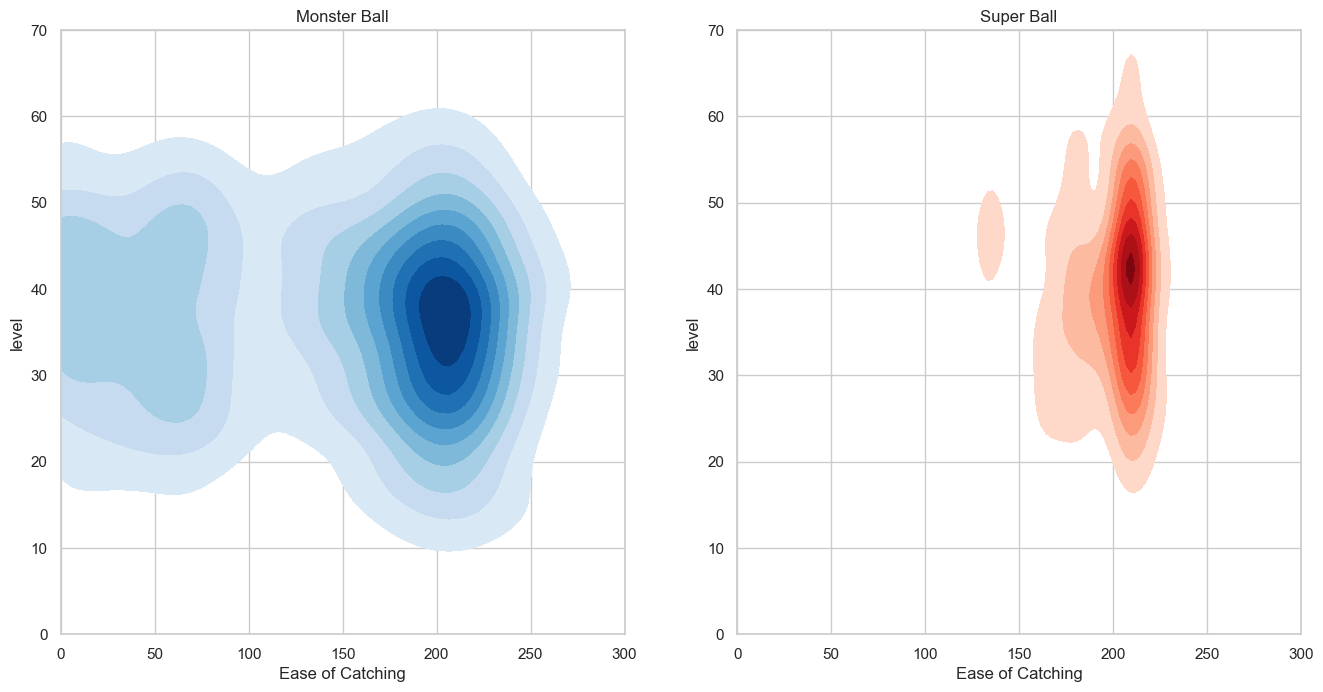

In [19]:
df_copy = df.copy()
df_copy['ease'] = 255 - df_copy['rarity']
df_copy = df_copy.set_index('ball')
df_monster = df_copy.loc[['monster'],['ease', 'level']]
df_super = df_copy.loc[['super'],['ease', 'level']]
plt.figure(figsize=(16,8), dpi=100)

plt.subplot(121)
sns.kdeplot(df_monster.ease, df_monster.level, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 300)
plt.ylim(0, 70)
plt.title('Monster Ball')
plt.xlabel('Ease of Catching')

plt.subplot(122)
sns.kdeplot(df_super.ease, df_super.level, cmap='Reds', shade=True, shade_lowest=False)
plt.xlim(0, 300)
plt.ylim(0, 70)
plt.title('Super Ball')
plt.xlabel('Ease of Catching')

plt.show()

横軸がレア度から算出された「ポケモンの捕まえやすさ」を表す軸でこらが大きいほど捕まえやすいことを表す。縦軸がレベルである。この二つのグラフはモンスターボールとスーパーボールがそれぞれどの様な場面で利用されるのかを可視化している。モンスターボールは幅広く使われているのに対して、スーパーボールは比較的捕まえずらいポケモンに集中して使われていることがわかる。あまり顕著では無いが、レベルに関しても同じことが言える。幅広いレベルのポケモンを捕まえるのに使われているモンスターボールと比べてスーパーボールが使われるのはレベルが高いポケモンの集中しているように見える。

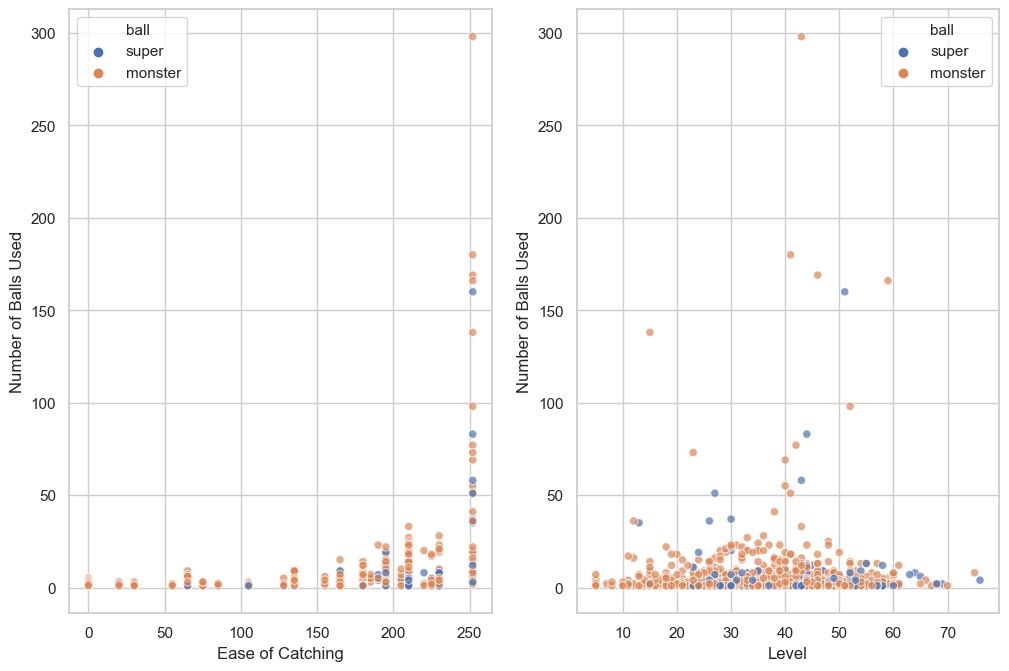

In [20]:
df_copy = df_copy.reset_index()

plt.figure(figsize=(12,8), dpi=100)

plt.subplot(121)
sns.scatterplot('ease', 'n_balls', hue='ball', alpha=0.7, data=df_copy)
plt.ylabel('Number of Balls Used')
plt.xlabel('Ease of Catching')

plt.subplot(122)
sns.scatterplot('level', 'n_balls', hue='ball', alpha=0.7, data=df_copy)
plt.ylabel('Number of Balls Used')
plt.xlabel('Level')
plt.show()

左手のグラフは「捕まえやすさ」と「捕獲に使ったボールの数」に対し、右手のグラフは「レベル」と「捕獲に使われたボールの数」の散布図である。左側のグラフから、明らかに捕まえずらいポケモンに対してスーパーボールが多く使われていることがわかる。

これらのグラフから、「ポケモンの捕まえやすさ」(独立変数)は、「どのボールを使うか」(独立変数)と「捕獲に使ったボールの数」(従属変数)の両方に影響を与えている事がわかった。このような統計モデルにおける従属変数と独立変数の両方に相関する変数のことを**交絡因子(Confounding Factor)**と言う。これを無視したまま、効果検証を行うと、実際の効果と違う結果がでてしまう。今回の場合も、捕まえずらいポケモンに対して多く使われるスーパーボールは明らかにモンスターボールに比べて不利な戦いを強いられていることがわかる。

そこでオーキド博士は線形重回帰を用いたモデル化を行い、「ポケモンのつかまえやすさ」の影響を取り除いたうえで、改めて「スーパーボールは本当にモンスターボールより捕まえやすいのか？」という仮説を検証することにしました。-- [「ポケモンを題材に因果推論を実践してみる」](https://tepppei.hatenablog.com/entry/2020/05/05/113514)より

## 6. 線形重回帰によるモデル化
データの数とNとし、「ポケモンの捕まえやすさ」を表す確率変数を$X_1, X_2, ..., X_N$、「どのボールを使ったか(スーパーボールなら1、モンスターボールなら0)」を表す確率変数を$Z_1, Z_2, ..., Z_N$、「ポケモンを捕まえるのにあたって使ったボールの数」を表す確率変数を$Y_1, Y_2, ..., Y_N$とする。$X,Y,Z$には次のような関係がある。

\begin{equation}
Y=\mathbf{X}\beta+\epsilon
\end{equation}

ここで、$\mathbf{X}$はDesign Matrixと呼ばれ、$N\times3$の行列で、1列目は$(1,1,...,1)^T$、2列目は$(X_1,X_2,...,X_N)^T$、3列目は$(Z_1,Z_2,...,Z_N)^T$である。また$\beta$は3次元ベクトル$\beta_0,\beta_1,\beta_2$とする。$\epsilon$は誤差項と呼ばれるN次元の確率変数で、$\epsilon$を$\mathbf{X}$で条件づけた分布は、平均0・各要素の分散が$\sigma^2$で各要素が無相間のN次元正規分布に従うと仮定する。ちなみに、もし被説明変数である$Y$に影響を与える変数がが制御されていない場合、その効果は$\epsilon$に含まれることになってしまい、この仮定が成り立たなくなってしまう。この時上記の式の条件付き期待値をとると、

$$E[Y|\mathbf{X}] = \mathbf{X}\beta$$

となる事がわかり、この式はXを固定した時のYの期待値を線形のモデルとしてモデリングを行っている。これは線形回帰分析の授業で習った。私たちは最小二乗法(Ordinary Least Squares)を使って真のパラメータ$\beta$を推定した$\hat\beta$を得る事ができます。では、早速Pythonでやってみよう。

Pythonで線形回帰分析を行う方法はいくつかあるが、計量経済学で因果推論をする時は`Statsmodels`ライブラリを使う方がいいと思う。と言うのも、この後でわかるように、パラメーターの平均や標準偏差、$R^2$など様々な結果を全てわかりやすく表示してくれるからだ。また、`statsmodels.formula.api`にはRで使われるような変数指定の表現ができるため、簡単に使えるのも一つの魅力である。

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
results = smf.ols('n_balls ~ rarity + ball', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                n_balls   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     40.33
Date:                Mon, 11 May 2020   Prob (F-statistic):           1.43e-17
Time:                        13:37:07   Log-Likelihood:                -4189.9
No. Observations:                1000   AIC:                             8386.
Df Residuals:                     997   BIC:                             8400.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.1496      0.983     13.374

上の表は、OLSによる結果をまとめたものである。私たちが注目したいのは回帰係数$\beta$に関する様々な情報ををまとめた上から二つめのテーブル。その中で見るのは`ball[T.super]`の一行である。coefの値が$-4.95$になっているのがわかる。これは

**「その他の全ての変数を固定したとき、スーパーボールを使った場合、モンスターボールを使った時と比べて、使用するボールの個数が平均的に-4.45個減少する」**

ことを意味する。また、最後の三つの値は$\beta = 0$を帰無仮説としたのt-検定のtest statistic、p-value、そして95%信頼区間である。この95%信頼区間に0が含まれていないことから、

**「その他全ての変数を固定したとき95%の有意水準でスーパーボールはモンスターボールよりポケモンを捕まえやすく、平均的に節約できるボールの数は2から7個の間にある」**

と言うふうに解釈することができる。これによって、スーパーボールはモンスターボールよりポケモンを捕まえやすいと言うことが統計的に示せた。

## 7. 欠落変数によるバイアス
しかしオーキド博士はまた考えた。「ポケモンの捕まえやすさは本当にレア度だけに依存するのか？」と。そしてこないだサトシにお願いしてロケット団から「ゲットだぜ！(盗んだ)」した論文を思い出した。論文にはポケモンに様々なポケモン実験(動物実験???)をした結果、HPが低いほど、そして麻痺、眠り、毒、火傷などといった状態異常になっていた時の方が捕まえやすいと書いてあった。オーキド博士は回帰モデルにポケモンの体力とステータスを含めなかったことによって**欠落変数バイアス**が生じているのではないかと考えた。

例えば、推定すべき回帰モデルが、

$$Y = \beta_0 + \beta_{1}X + \beta_{2}Z +  \epsilon$$

だったとする。しかし、回帰モデルに$Z$を含めなかったとする。すると実際に推定する事ができる回帰モデルは

$$Y = \beta_0 + \beta_{1}X + V$$
$$V = \beta_{2}Z + \epsilon$$

ここで、
$$\hat\beta_{1} = \frac {Cov(x_i, y_i)}{Var(x_i)} = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum(x_i - \bar{x})^2} \\
= \frac{\sum(x_i-\bar{x})y_i}{\sum(x_i - \bar{x})x_i}
$$

この式の$y_i$に、真のモデル$y_i = \beta_0 + \beta_1x_i + \beta_2z_i+\epsilon_i$を代入して整理すると、

$$\hat{\beta_1}=\beta_1 + \beta_2\frac{\sum(x_i-\bar{x})z_i}{\sum(x_i-\bar{x})x_i}+\frac{\sum(x_i-\bar{x})\epsilon_i}{\sum(x_i-\bar{x})x_i}$$

そして期待値をとると、
$$E[\hat\beta|X] = \beta_1 + \beta_2\rho$$ 

となる事がわかり、真の$\beta_1$に$\beta_2\rho$のバイアスが足されていることがわかる。ちなみに、$\rho$は$\hat\beta_1$の式の第二項に着目すると、$Z$と$X$を回帰させた時のパラメーターであることがわかる。

欠落変数のよるバイアスを取り除くために、オーキド博士はHPと状態異常のパラメーターを加えた再びOLSをしてみた。その結果が以下である。

In [23]:
results = smf.ols('n_balls ~ rarity + state + hp + ball', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                n_balls   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     10.91
Date:                Mon, 11 May 2020   Prob (F-statistic):           7.90e-15
Time:                        14:11:45   Log-Likelihood:                -4186.6
No. Observations:                1000   AIC:                             8391.
Df Residuals:                     991   BIC:                             8435.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.5747      2

各状態異常およびHPに関する回帰係数とそれに対するp値を見る限り、どうやら95%有意水準ではポケモンを捕まえるのに使用するボールの個数と統計的に有意な関係はないという結論に至った。そして使用したボールに関する回帰係数を見ても、他の変数を含めた前のモデルと比べて対して変化がない事がわかる。

## 7. 頑健な標準誤差(Robust Standard Deviation)
欠落変数によるバイアスがないとわかったオーキド博士はいよいよ研究を仕上げの段階に持っていこうとした。できるだけ正確にボールの種類によって生じる違いを推定するために、推定したモデルの**残差**に着目した。

### 残差分布 
線形回帰分析には、

$$\epsilon \sim N(0, \sigma^2) $$

つまり、誤差項$\epsilon$が平均0分散$\sigma^2$一定の標準分布に従うという前提がある。この前提が満たされていないが誤差項の分散が不変だと仮定してパラメーター$\beta$の標準偏差をすると正しい値を得られず、正しい信頼区間になってしまったり、最悪の場合統計的有意かどうかの判定も誤ってしまう可能性がある。そのため、残差項の分布をチェックしておく必要がある。

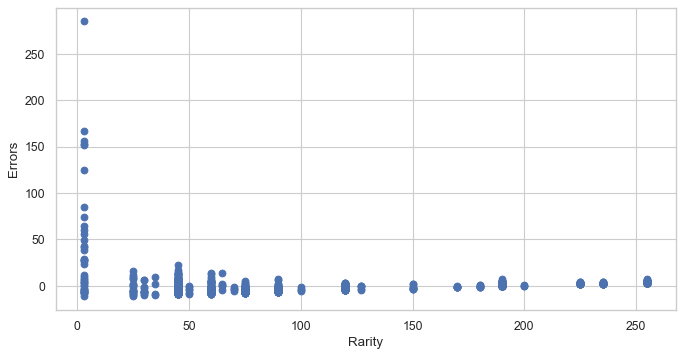

In [31]:
results = smf.ols('n_balls ~ rarity + ball', data=df).fit()
errors = df.n_balls - results.predict()
fig = plt.figure(figsize=(10,5), dpi=80)
ax = fig.add_subplot(111)
ax.scatter(df.rarity, errors)
ax.set(xlabel = 'Rarity', ylabel='Errors')
plt.show()

上のグラフは「レア度」に対して「誤差」をプロットしたものである。明らかにレア度が変化すると分散も変化している事がわかる。つまり、分散が一定という前提は守られていないことになる。このようなときに使うのは**頑健な標準誤差**であり、`Statsmodels`では`get_robustcov_results()`メソッドを使うことによって、自動的に計算してくれる。

In [30]:
robust_res = results.get_robustcov_results()
print(robust_res.summary())

                            OLS Regression Results                            
Dep. Variable:                n_balls   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     20.89
Date:                Mon, 11 May 2020   Prob (F-statistic):           1.29e-09
Time:                        14:36:44   Log-Likelihood:                -4189.9
No. Observations:                1000   AIC:                             8386.
Df Residuals:                     997   BIC:                             8400.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.1496      1.705      7.711

上の表が頑健な標準誤差を利用して推定したボールの効果である。95%信頼区間の幅が以前と比べて少し広くなった事がわかる。オーキド博士はこの結果に満足して、**「スーパーボールはモンスターボールよりポケモンを捕まえやすい」**という結論を発表した。

## 8. まとめ
今回の分析は計量経済学の基本的な手法を勉強するのにあたって良いものとなった。自分でモデリングしてシミュレーションしているため、何が交絡因子なのか、欠落変数はあるのかなど事前に分かっていた。しかし、実際の場合こんな簡単にいくわけがない。また今回は基本的な線形重回帰モデルを利用したが、場合によってモデルが出す予想値がマイナスの値をとることがあるので、本当は適切でない(使用するボールの数が1を下回ることはないから)。ポアソン回帰などもう少し高度なモデルを使ったほうがより正しい効果を推定することができると考えられる。